<a href="https://colab.research.google.com/github/IBS-Wos-Search/Auto-script/blob/main/Clarivate_WoS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rispy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests
import json
import time
import re
import csv
import rispy

Get the author list

In [ ]:
authors_url = 'https://gist.githubusercontent.com/ibshelp/1c078ff8692574ba0e5665b7372c973f/raw/c4d04643b246a0802003bde1e22f5df5679c6de8/IBS%2520Researchers'

author_list = requests.get(authors_url).text.split('\n')
print(f'First record: {author_list[0]}\nLast record: {author_list[-1]}')

First record: Andersson, Krister
Last record: Yeatman, Sara


Go get the API definition

In [ ]:
base_url = 'https://wos-api.clarivate.com/api/woslite'
#base_url = 'https://wos-api.clarivate.com/api/wos'
api_key = '98c6817fc891c194dce9ed0170cddf259d092a87'
api_user = 'b681ff0ecd9c154da0dc8e22f9cae39d6ffb4409'

result = requests.get(f'{base_url}/swagger?forUser={api_user}').json()

with open('swagger_def.txt', 'w') as file:
    file.write(json.dumps(result, indent=2))

Do a search using the specification on line 18 in the WOSLite database and dump 
the results to test.txt for debugging.

In [ ]:
# Andy Baker
# symbolicTimeSpan= '1week', '2week', '4week'
# TimeSpan

headers = {
    "X-ApiKey": api_key
}

query = {
    "databaseId": "WOS",
    "count": 100,
    "firstRecord": 1,
    "usrQuery": "",
    "sortField": "",
    "symbolicTimeSpan": ""
}

query['usrQuery'] = 'TS=(("latin america" OR "Brazil" OR "Mexico" OR "Chile" OR "Argentina" OR "Uruguay" OR "Peru" OR "Colombia" OR "Bolivia") AND (“labor” OR “labour” OR "welfare" OR "social policy" OR "government expenditure*" OR "health policy" OR "anti-poverty" OR "antipoverty" OR "transfer*" OR "health sector" OR "pension*") NOT ("mental health")) AND LA=("English" OR "Portuguese" OR "Spanish")'
query['symbolicTimeSpan'] = '4week'

result = requests.get(f'{base_url}/', headers=headers, params=query).json()

print(f"Found {result['QueryResult']['RecordsFound']} result(s)")

with open('test.txt', 'w') as file:
    file.write(json.dumps(result, indent=2))

Found 33200 result(s)


Convert the result to RIS format for output and write to test.ris

In [ ]:
# https://github.com/MrTango/rispy

entries = []
for record in result['Data']:
    cleaned_record = {
        'primary_title': record.get('Title', {}).get('Title')[0],
        'authors': record.get('Author', {}).get('Authors'),
        'publication_year': record.get('Source', {}).get('Published.BiblioYear')[0],
        'keywords': record.get('Keyword', {}).get('Keywords', []),
        'accession_number': record.get('UT'),
        'secondary_title': record.get('Source', {}).get('SourceTitle')[0],
    }

    reference_type = record.get('Doctype', {}).get('Doctype')[0]
    if reference_type == "Article":
        cleaned_record['type_of_reference'] = "EJOUR"
    else:
        ris_type = [k for k, v in rispy.TYPE_OF_REFERENCE_MAPPING.items() if v == reference_type]
        if ris_type == []:
            cleaned_record['type_of_reference'] = "GEN"
        else:
            cleaned_record['type_of_reference'] = ris_type[0]


    doi = record.get('Other', {}).get('Identifier.Doi')
    if doi:
        cleaned_record['doi'] = doi[0]

    issn = record.get('Other', {}).get('Identifier.Issn')
    if issn:
        cleaned_record['issn'] = issn[0]

    pages = record.get('Source', {}).get('Pages')
    if pages and pages[0] != "":
        cleaned_record['start_page'] = pages[0].split('-')[0]
        cleaned_record['end_page'] = pages[-1].split('-')[-1]
    
    issue_number = record.get('Source', {}).get('Issue')
    if issue_number:
        cleaned_record['number'] = issue_number[0]

    volume = record.get('Source', {}).get('Volume')
    if volume:
        cleaned_record['volume'] = volume[0]
    
    date = record.get('Source', {}).get('Published.BiblioDate')
    if date and '-' not in date[0]:
        months = {
            'JAN': '01',
            'FEB': '02',
            'MAR': '03',
            'APR': '04',
            'MAY': '05',
            'JUN': '06',
            'JUL': '07',
            'AUG': '08',
            'SEP': '09',
            'OCT': '10',
            'NOV': '11',
            'DEC': '12'
        }
        year = cleaned_record.get('publication_year')
        date_field = date[0].split(' ')
        month = months.get(date_field[0].upper(), "")
        day = "" if len(date_field) == 1 else date_field[1]
        date_string = f"{year}/{month}/{day}/undefined"
        
        cleaned_record['date'] = date_string

    entries.append(cleaned_record)

with open('test.ris', 'w') as file:
    rispy.dump(entries, file)

**Below this is old code that shouldn't be run!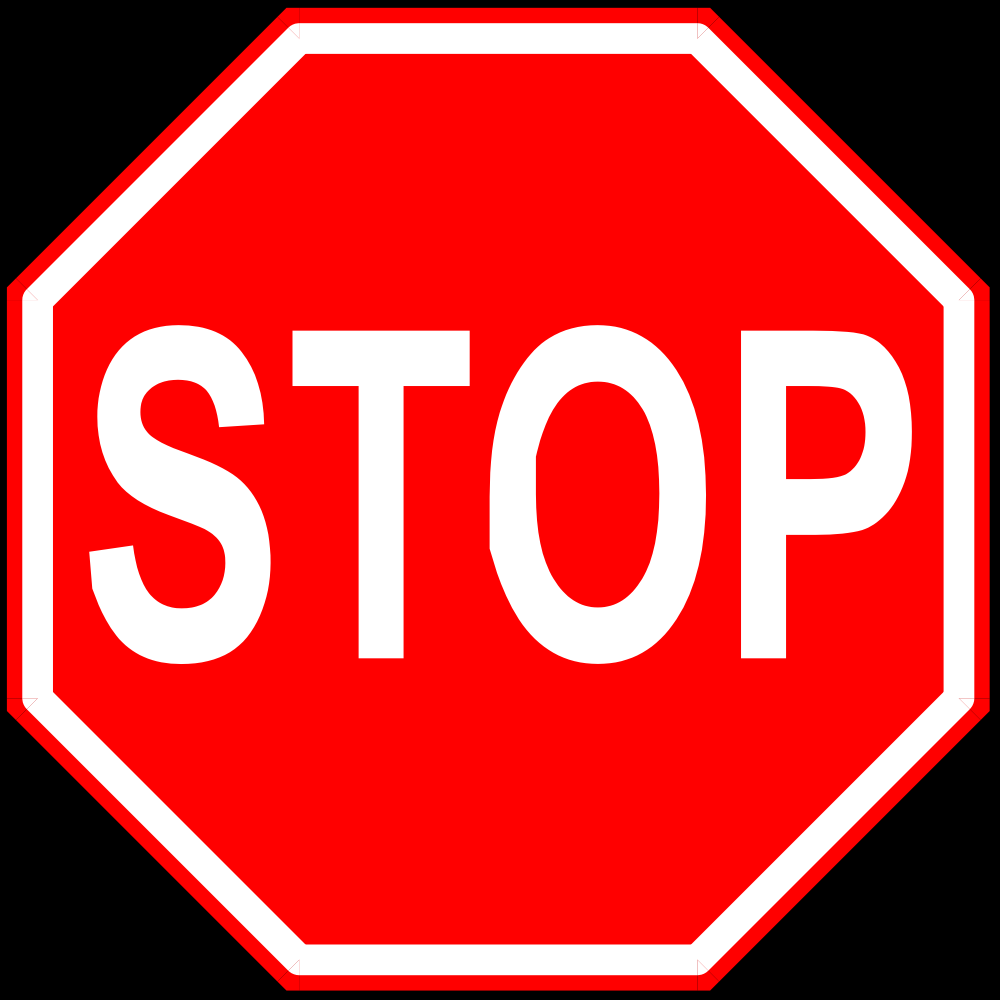**

In [ ]:
(headers = {
    "X-ApiKey": api_key
}

query = {
    "databaseId": "WOS",
    "count": 100,
    "firstRecord": 1,
    "usrQuery": "",
    "sortField": ""
}

query['usrQuery'] = 'RI=K-6682-2012'
result = requests.get(f'{base_url}/', headers=headers, params=query).json()
print(json.dumps(result, indent=2))

print(f"Found {result['QueryResult']['RecordsFound']} result(s)")

lowest_year = 2021
for pub in result['Data']:
    if 'Published.BiblioYear' in pub['Source'] and int(pub['Source']['Published.BiblioYear'][0]) < lowest_year:
        lowest_year = int(pub['Source']['Published.BiblioYear'][0])

print(f'Earliest Publication from {lowest_year}')

with open('test.txt', 'w') as file:
    file.write(json.dumps(result, indent=2))

SyntaxError: ignored

In [ ]:
author_id_regex = re.compile(r'[A-Z]\-[0-9]{4}\-[0-9]{4}')

headers = {
    "X-ApiKey": api_key
}

query = {
    "databaseId": "WOS",
    "count": 100,
    "firstRecord": 1,
    "usrQuery": "",
    "sortField": ""
}
results_list = []
missed_authors = []

for author in author_list:
    time.sleep(.25)
    author_name = author.strip()
    if author_id_regex.match(author_name):
        query['usrQuery'] = f'RI={author_name}'
    else:
        query['usrQuery'] = f'AU={author_name}'
    result = requests.get(f'{base_url}/', headers=headers, params=query).json()
    if 'Data' in result and result['Data']:
        print(f"Found {result['QueryResult']['RecordsFound']} result(s) for {author.strip()}")
        results_list.extend(result['Data'])
    else:
        missed_authors.append(author_name)

print(f'{len(results_list)} records returned')

with open('results.txt', 'w') as file:
    file.write(json.dumps(results_list, indent=2))

with open('still missed.txt', 'w') as file:
    file.write('\n'.join(missed_authors))

Found 65 result(s) for Andersson, Krister
Found 15 result(s) for Atteberry, Allison
Found 10 result(s) for Barham, Tania
Found 30 result(s) for Bearce, David
Found 33 result(s) for Belknap, Joanne
Found 78 result(s) for Bernstein, Robin
Found 3 result(s) for Blechman, Elaine
Found 101 result(s) for Boardman, Jason D.
Found 27 result(s) for Boulding, Carew
Found 4 result(s) for Boulding, Elise
Found 31 result(s) for Boulding, Kenneth E
Found 22 result(s) for Bourne, Lyle E. Jr.
Found 1 result(s) for Bramsen, John
Found 35 result(s) for Brenkert-Smith, Hannah
Found 287 result(s) for Bryan, Angela
Found 14 result(s) for Buckley, Pamela
Found 11 result(s) for Cadena, Brian
Found 3 result(s) for Costa, Frances
Found 13 result(s) for Cronshaw, Mark
Found 194 result(s) for Davis, Keith


KeyboardInterrupt: ignored

In [ ]:
pub_citation_list = []
for pub in results_list:
    pub_citation_list.append((pub['Title']['Title'][0], '; '.join(pub['Author']['Authors']), pub['Source']['Published.BiblioYear'][0]))

In [ ]:
pub_citation_headers = ('Title', 'Author(s)', 'Year')
pub_citation_list.insert(0,pub_citation_headers)
filename = 'Missed Authors from Google.csv'
with open(filename, 'w', newline='', encoding='utf-8-sig') as csvfile:
  writer = csv.writer(csvfile)
  writer.writerows(pub_citation_list)